## Introduction
#### Variational Autoencoder for Deep Learning of Images, Labels and Captions

This notebook aims to document the process of implementing [this paper](https://proceedings.neurips.cc/paper/2016/file/eb86d510361fc23b59f18c1bc9802cc6-Paper.pdf) from scratch.
I used [this article](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) to help me get a better intution of what varitional autoencoders do. I recently learnt about autoencoders from my dimensionality reduction class in CSC311 offered by UofT, however they just gave us a very brief introduction to them. Nevertheless, the intutions of the varitional autoencoder makes sense to me. 

#### Convolution Review

I was quite rusty with how traditional convolutions networks worked, and so I had to do a quick review. [This article](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) was a great help for getting me to re-understand it much quicker. 

Diving deep into "convolution" and "cross correlation" lead into a lot of signal processing which I am unfamiliar with. I feel that all I need to know is that convolution performs cross correlation with flipped kernels. Pytorch performs cross correlation, so I won't have to flip kernels here. 

In [1]:
import torch.nn as nn 
import torch.nn.functional as F
import torch
import numpy as np
from scipy import ndimage
import itertools
import torch.nn.init as init
import math
from torch.distributions.multivariate_normal import MultivariateNormal

In [2]:
a_test = np.array([[[1, 2, 0, 0],
               [5, 3, 0, 4],
               [0, 0, 0, 7],
               [9, 3, 0, 0]], 
              
              [[7, 2, 2, 0],
               [4, 3, 0, 1],
               [0, 5, 0, 0],
               [0, 2, 1, 1]]])

k_test = np.array([[[1,1,1],[1,1,0],[1,0,0]], [[1,1,1],[1,0,1],[1,1,1]]])

In [3]:
ndimage.correlate(a_test[0, ...], k_test[0, ...], mode='constant', cval=0) + \
ndimage.correlate(a_test[1, ...], k_test[1, ...], mode='constant', cval=0)

array([[10, 24, 11,  3],
       [25, 31, 18,  6],
       [22, 27, 23, 14],
       [16, 18, 18,  8]])

In [4]:
tensor_a = torch.FloatTensor(a_test[np.newaxis, ...])
tensor_k = torch.FloatTensor(k_test[np.newaxis, ...])

In [5]:
F.conv2d(tensor_a, tensor_k, padding=1)

tensor([[[[10., 24., 11.,  3.],
          [25., 31., 18.,  6.],
          [22., 27., 23., 14.],
          [16., 18., 18.,  8.]]]])

In [6]:
a_test = torch.rand(1, 1, 5, 5)
k_test = torch.rand(2, 1, 3, 3)

In [7]:
np.stack([ndimage.correlate(a_test[0, ...], k_test[0, ...], mode='constant', cval=0), \
         ndimage.correlate(a_test[0, ...], k_test[1, ...], mode='constant', cval=0)], axis=1)

array([[[[0.32644776, 0.4368712 , 0.35318005, 0.7674539 , 0.895265  ],
         [0.7926608 , 1.6193941 , 1.2907488 , 1.3212491 , 1.0629072 ],
         [1.3301716 , 2.1398847 , 1.9209682 , 2.020923  , 1.1743714 ],
         [1.0162964 , 2.313112  , 2.0096335 , 2.086295  , 1.6521789 ],
         [0.93057394, 1.7167659 , 1.9477324 , 1.9742621 , 1.8312017 ]],

        [[0.7284218 , 1.5049825 , 1.4446185 , 2.048427  , 0.74198586],
         [2.014626  , 3.0170088 , 1.7462041 , 1.9341929 , 1.8349692 ],
         [1.8427386 , 2.759331  , 2.7655177 , 3.52508   , 1.9118936 ],
         [2.0676355 , 3.3261514 , 3.6520622 , 2.7186403 , 2.2854593 ],
         [1.3174242 , 1.3933154 , 1.6284589 , 1.850345  , 1.4532061 ]]]],
      dtype=float32)

In [8]:
F.conv2d(a_test, k_test, padding=1)

tensor([[[[0.3264, 0.4369, 0.3532, 0.7675, 0.8953],
          [0.7927, 1.6194, 1.2907, 1.3212, 1.0629],
          [1.3302, 2.1399, 1.9210, 2.0209, 1.1744],
          [1.0163, 2.3131, 2.0096, 2.0863, 1.6522],
          [0.9306, 1.7168, 1.9477, 1.9743, 1.8312]],

         [[0.7284, 1.5050, 1.4446, 2.0484, 0.7420],
          [2.0146, 3.0170, 1.7462, 1.9342, 1.8350],
          [1.8427, 2.7593, 2.7655, 3.5251, 1.9119],
          [2.0676, 3.3262, 3.6521, 2.7186, 2.2855],
          [1.3174, 1.3933, 1.6285, 1.8503, 1.4532]]]])

### Image decoder: DDGM

First I have to create the operation defined in (1) and (3).  

For the convolution, it wasn't clear to me what the padding and stride were, so I assumed that we stick to CNN conventions and make the output shape the same as the input shape. 

In [9]:
def DDGM_convolve(D, S):
    """
    Perform sum_(kl) D^(kl, l) * S^(n, kl, l) as described in the paper. 
    D: 4D tensor with shape (KL-1, KL, kW, kH)
        KL-1: Number of "slices" in the previous layer. I.e the out channel. 
        KL: Number of "slices" in the current layer. I.e the in channel.
        kW, kH: kernel width and kernel height
    
    S: 3D tensor with the shape (KL, cW, cH)
        KL: Number of 2D slices
        iW, iH: code width and code height
    """
    result = None
    kernel_size = D.shape[2]
    for i in range(D.shape[1]):
        D_kl = D[:, i, ...].unsqueeze(1)
        S_kl = S[i, ...].unsqueeze(0).unsqueeze(0)
        current_sum = F.conv2d(S_kl, D_kl, stride=1, padding=(kernel_size-1)//2)
        
        if result is None:
            result = current_sum
        else:
            result += current_sum
        
    return result.squeeze(0)

In [10]:
D = torch.rand((5, 3, 5, 5), requires_grad=True)
S = torch.rand((3, 28, 28))
DDGM_convolve(D, S).shape

torch.Size([5, 28, 28])

Then, I have to create a unpooling layer as defined in (2). I copied an excerpt of it here: 


For the stochastic unpooling, $S^{(n,k1 ,1)}$ is partitioned into contiguous $px × py$ pooling blocks (analogous to pooling blocks in CNN-based activation maps). Let $ z^{(n,k1 ,1)}_{i, j} \in \{0, 1\}^{px py}$ be a vector
of $pxpy − 1$ zeros, and a single one; $z^{(n,k1 ,1)}_{i, j}$ corresponds to pooling block $(i, j)$ in $S^{(n,k1 ,1)}$. 


The location of the non-zero element of $z^{(n,k1 ,1)}_{i, j} $ identifies the location of the single non-zero element $i,j$
in the corresponding pooling block of $S^{(n,k1 ,1)}$. 


The non-zero element in pooling block $(i,j)$ of $S^{(n,k1 ,1)}$ is set to $\tilde{S}_{i, j}^{(n,k1,2)}$, i.e., element $(i,j)$ in slice k1 of $\tilde{S}^{(n,2)}$. 

Within the prior of the decoder, we impose z(n,k1,1) ∼ Mult(1; 1/(pxpy), . . . , 1/(pxpy)). 

Both $\tilde{S}^{(n,2)}$ and $S^{(n,2)}$ are 3D tensors with K1 2D slices; as a result of the unpooling, the 2D slices in the sparse $S^{(n,2)}$ have $pxpy$ times more elements than the corresponding slices in the dense $\tilde{S}^{(n,2)}$.

I tried to illustrate what is I believe is happening below:

<img src="./images/figure1.jpg" width="600">


In [11]:
def unpool(S, prob_vecs):
    """
    Performs stochastic unpooling on S where the location of the non zero element in each pooling block (i, j)
    in layer k is defined by z^k (i, j), and z^k, (i, j) 
    is sampled from a multinomial distribution Mult(1, prob_vecs(k, i, j)).
    
    Initially, each prob_vec = (1/(pxpy), ... 1/(pxpy)), i.e the prior distribution. 
    
    The shape of each prob_vec must be pool_size**2. Here we are assuming that our pooling blocks
    will always be square.
    
    S: 3D tensor with the shape (KL, cW, cH)
    
    prob_vecs: 4D tensor with the shape (KL, cW, cH, pool_size**2):
        pool size: px * py
    """
    
    K, w, h = S.shape
    pool_size = int(math.sqrt(prob_vecs.shape[3])) # We are assuming that the pooling blocks are square.
    
    result = torch.zeros(K, w*pool_size, h*pool_size)
    for k in range(K):
        for block in itertools.product(range(w), range(h)):
            i, j = block
            z = torch.zeros(pool_size**2)
            idz = torch.multinomial(prob_vecs[k, i, j], 1).item()
            z[idz] = S[k, i, j]
            result[k, i*pool_size:(i+1)*pool_size, j*pool_size:(j+1)*pool_size] = z.reshape(-1, pool_size)
    
    return result

While implementing the loss, I believe I misunderstood the unpooling process. I was under the impression that the encoding and decoding layer simply shared _distributions_ , where in fact they share _z_ itself. I.e we only perform sampling in the encoder's pooling layer, and we reuse those samples in the unpooling layer.

In [12]:
def unpool(S, z, pool_size):
    """
    Performs stochastic unpooling on S where the location of the non zero element in each pooling block (i, j)
    in layer k is defined by z(i, j)^k.
    
    S: 3D tensor with the shape (KL, cW, cH)
    z: 3D tensor with the shape (KL, cW, cH)
        Each value in z ranges from 0 inclusive to pool_size**2 exclusive.
        
        
    """
    K, w, h = S.shape
    result = torch.zeros(K, w*pool_size, h*pool_size)
    
#     for k in range(K):
#         for block in itertools.product(range(w), range(h)):
#             i, j = block
#             unpool_block = torch.zeros(pool_size**2)
# #             idz = torch.multinomial(prob_vecs[k, i, j], 1).item()
#             idz = z[k, i, j]
#             unpool_block[idz] = S[k, i, j]
#             result[k, i*pool_size:(i+1)*pool_size, j*pool_size:(j+1)*pool_size] = unpool_block.reshape(-1, pool_size)
            
    
    for block in itertools.product(range(w), range(h)):
        i, j = block
        unpool_block = torch.zeros(K, pool_size**2)
        idz = z[np.arange(K), i, j]
        unpool_block[np.arange(K), idz] = S[np.arange(K), i, j]
        result[np.arange(K), i*pool_size:(i+1)*pool_size, j*pool_size:(j+1)*pool_size] = \
        unpool_block.reshape(K, -1, pool_size)
    
    return result
        
    
    
    

With these two functions, we can implement the DDGM. For the data generation layer, I used the trick described in 
[this article](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73). 

$$X^{(n)} \sim \mathcal{N}(\tilde{S}^{(n, 1)}, \alpha_0^{-1} \textbf{I})$$

can be expressed as: 

$$X^{(n)} = \tilde{S}^{(n, 1)} + \alpha_0^{-1} Z $$

Where $Z \sim \mathcal{N}(\textbf{0}, \textbf{I})$ due to the linearity of gaussian distributions. This allows backprop to "reach" the dictionary layers as we seperate the random process. I believe this is called a 'reparameterization trick'

Note that we are storing the $log \alpha_0$ to ensure that the precision will always be positive.



In [13]:
class DDGMDecoder(nn.Module):
    """
    A 2 layered DDGM decoder, with a stochastic unpooling layer between the two layers,
    and a final data generation layer. 
    """
    def __init__(self, K2, K1, Nc, d2_kernel, d1_kernel, iW, iH, pool_size=3):
        """
        d2 is of shape (K1, K2, kW, kH)
            K1: Number of "slices" in layer 1
            K2: Number of "slices" in layer 2
            kW, kH: kernel width, kernel height
            
        d1 is of shape(Nc, K1, kW, kH):
            Nc: Number of channels of the image (1 for grayscale, 3 for rgb)
            K1: Number of "slices" in layer 1
            kW, kH: kernel width, kernel height
            
        distribution is of shape (iW, iH, pool_size**2):
            iW, iW: input width, input height
        """
        
        super().__init__()
        self._d2 = nn.Parameter(torch.Tensor(K1, K2, d2_kernel, d2_kernel))
        self._d1 = nn.Parameter(torch.Tensor(Nc, K1, d1_kernel, d1_kernel))
        self._pool_size = pool_size
        
        # See above for my misunderstanding
        
        # Uniformly distributed, equal to 1/pxpy, 1/pxpy... 
        # self._distribution = torch.ones(K1, iW, iH, pool_size**2) 
        
        self._precision = nn.Parameter(torch.rand(1))
        self._reset_parameters()
        
    # Initialization method is taken from the pytorch implementation of CNNs. 
    # https://pytorch.org/docs/stable/_modules/torch/nn/modules/conv.html#Conv2d
    
    def _reset_parameters(self):
        init.kaiming_uniform_(self._d2, a=math.sqrt(5))
        init.kaiming_uniform_(self._d1, a=math.sqrt(5))
        
    def get_precision(self):
        return self._precision
        
    def forward(self, x, z):
        """
        X: code generated from encoder
            Shape: (K2, iW, iH)
        
        z: Unpooling map generated from the encoder.
            Shape: (K2, iW, iH)
        
        
        """
        S2 = DDGM_convolve(self._d2, x)
        S1 = unpool(S2, z, self._pool_size)
#         x = unpool(x, self._distribution)
        S1 = DDGM_convolve(self._d1, S1)
        
        # Data Generation
        Z = MultivariateNormal(torch.zeros(S1.shape[1]*S1.shape[2]), torch.eye(S1.shape[1]*S1.shape[2]))
        slices = []
        for k in range(S1.shape[0]):
            mean = S1[k, ...].reshape(-1)
            
            
            covar = (1/(torch.exp(self._precision) ** 0.5))*(Z.sample())
            slice_ = (mean + covar).reshape(S1.shape[1], -1)
            slices.append(slice_)
            
        # See loss on why we return S1
        return torch.stack(slices), S1
    
#     def set_distribution(self, distribution):
#         """
#         Sets the distribution for stochastic unpooling.
#         """
#         self._distribution = distribution

In [14]:
ddgm = DDGMDecoder(K2 = 6, K1 = 4, Nc = 3, d2_kernel=3, d1_kernel=3, iW=10, iH=10)
# ddgm(torch.rand(6, 10, 10))

###  Image Encoder: Deep CNN

For the encoder, we can employ pytorch's conv2d modules as they perform the convolution that we need, and thus we do not need to define our own convolution method as we did above. However, we do need to create our own pooling function. 

In [15]:
def pool(C, prob_vecs, pool_size):
    """
    Performs stochastic pooling on C, where the location of the element chosen in each pooling block (i, j)
    in layer kis determined by z^k (i, j), and z(i, j) is sampled from a 
    multinomial distribution(1, prob_vecs[k, i, j]), and prob_vecs[k, i, j] is derived from 
    MLP(C^k (i, j)). 
    
    
    C is of size (Kl, iW, iH):
        KL: Number of 2D "slices". 
        iW, iH: image width, image height. 
        
    Returns: 
        Result: The result of the pooling. 
        z: The pooling map generated.
    
    
    """
    
    K, w, h = C.shape
    w_new, h_new = w//pool_size, h//pool_size
    result = torch.zeros(K, w_new, h_new)
    z = torch.zeros(K, w_new, h_new).type(torch.LongTensor)
    
#     for k in range(K):
#         for block in itertools.product(range(w_new), range(h_new)):
#             i, j = block
    
#             idz = torch.multinomial(prob_vecs[k, i, j], 1).item()
#             C_block = C[k, i*pool_size:(i+1)*pool_size, j*pool_size:(j+1)*pool_size].reshape(-1)
# #             prob_vec = F.softmax(mlp(C_block), dim=-1)
# #             idz = torch.multinomial(prob_vec, 1).item()
            
#             result[k, i, j] = C_block[idz]
#             z[k, i, j] = idz

    for block in itertools.product(range(w_new), range(h_new)):
        i, j = block
        idzs = torch.multinomial(prob_vecs[np.arange(K), i, j], 1).reshape(-1)
        C_blocks = C[np.arange(K), i*pool_size:(i+1)*pool_size, j*pool_size:(j+1)*pool_size].reshape(K, -1)
        result[np.arange(K), i, j] = C_blocks[np.arange(K), idzs]
        z[np.arange(K), i, j] = idzs
        
    return result, z
        

In [16]:
class CNNEncoder(nn.Module):
    """
    A 2 layered CNN encoder, with a stochasting pooling layer between the two layers,
    and a final code generation layer.
    """
    
    def __init__(self, Nc, K1, K2, f1_kernel, f2_kernel, iW, iH, pool_size=3):
        """
        Parameters:
        K1: Number of "slices" in layer 1
        K2: Number of "slices" in layer 2
        Nc: Number of channels of the image (1 for grayscale, 3 for rgb)
        iW, iW: input width, input height
        f1_kernel and f2_kernel: Size of the kernels for each of the filter banks.
        """
        
        super().__init__()
        self.layer1 = nn.Conv2d(Nc, K1, kernel_size=f1_kernel, padding=(f1_kernel-1)//2, bias=False)
        self.layer2 = nn.Conv2d(K1, K2, kernel_size=f2_kernel, padding=(f2_kernel-1)//2, bias=False)
        
        # MLP for distribution of stochastic pooling
        self.mlp_pool = nn.Sequential(
            nn.Linear(pool_size**2, 20), # 20 is randomly chosen here.
            nn.Tanh(), 
            nn.Linear(20, pool_size**2)
        )
        
        self.mlp_shared = nn.Sequential(
            nn.Linear((iW//pool_size) * (iH//pool_size), 20),
            nn.Tanh()
        )
        
        self.mlp_mean = nn.Linear(20, (iW//pool_size) * (iH//pool_size))
        self.mlp_covar = nn.Linear(20, (iW//pool_size) * (iH//pool_size))
        
        
#         # MLP for code generation mean 
#         self.mlp_mean = nn.Sequential(
#             nn.Linear((iW//pool_size) * (iH//pool_size), 20),
#             nn.Tanh(), 
#             nn.Linear(20, (iW//pool_size) * (iH//pool_size))
#         )
        
#         # MLP for code generation covariance 
#         self.mlp_covar = nn.Sequential(
#             nn.Linear((iW//pool_size) * (iH//pool_size), 20),
#             nn.Tanh(), 
#             nn.Linear(20, (iW//pool_size) * (iH//pool_size))
#         )
        
        self._pool_size = pool_size
        
    def get_distribution(self, C):
        """
        Gets all the distributions for pooling, i.e the vector softmax(eta). 
        This distribution will be reused as the posterior for the decoder's unpooling as well.
        """
        K, w, h = C.shape
        pool_size = self._pool_size
        w_new, h_new = w // pool_size, h // pool_size
      
        result = torch.zeros(K, w_new, h_new, self._pool_size**2)
        for k in range(K):
            for block in itertools.product(range(w_new), range(h_new)):
                i, j = block
                C_block = C[k, i*pool_size:(i+1)*pool_size, j*pool_size:(j+1)*pool_size].reshape(-1)
                eta = self.mlp_pool(C_block)
                prob_vec = F.softmax(eta, dim=-1)
                result[k, i, j, :] = prob_vec
                
        return result

        
    def forward(self, x):
        """
        x: Input image
            Shape: (Nc, iW, iH)
        """
        
        C1 = self.layer1(x.unsqueeze(0))
        distribution = self.get_distribution(C1.squeeze(0))
        
        C1, z = pool(C1.squeeze(0), distribution, self._pool_size)
        C2 = self.layer2(C1.unsqueeze(0))
        C2 = C2.squeeze(0)
        
        # Final Code generation
        slices = []
        means = []
        covars = []
        Z = MultivariateNormal(torch.zeros(C2.shape[1]*C2.shape[2]), torch.eye(C2.shape[1]*C2.shape[2]))
        for k in range(C2.shape[0]):
            hidden = self.mlp_shared(C2[k, ...].reshape(-1))
            
            mean = self.mlp_mean(hidden)
            original_covar = self.mlp_covar(hidden)
            
            # Why are we doing exp here? In the supplementary paper (section 4), it is described that 
            # log sigma is created with the mlp, and therefore we need to perform exp() to get sigma.
            
            covar = torch.exp(torch.diag(original_covar)) @ Z.sample()
            slice_ = (mean + covar).reshape(C2.shape[1], -1)
            slices.append(slice_)
            means.append(mean)
            covars.append(original_covar)
    
        return torch.stack(slices), z, distribution, torch.stack(means), torch.stack(covars)
        # (s, z, eta, mu, sigma)

        

In [17]:
encoder = CNNEncoder(3, 4, 6, 3, 3, 32, 32)
s, z, eta, mu, sigma = encoder(torch.rand(3, 32, 32))
s.shape, z.shape, eta.shape, mu.shape, sigma.shape

(torch.Size([6, 10, 10]),
 torch.Size([4, 10, 10]),
 torch.Size([4, 10, 10, 9]),
 torch.Size([6, 100]),
 torch.Size([6, 100]))

### Putting the VAE together

Finally, we can piece the encoder and decoder together to form the VAE.

In [18]:
class VAE(nn.Module):
    
    def __init__(self, Nc, K1, K2, f1, f2, d2, d1, iW, iH, pool_size=3):
        """
        Nc: Number of channels of the image. 
        K1: Number of 2D "slices" in layer 1. This is shared for the encoder and decoder.
        K2: Number of 2D "slices" in layer 2. This is shared for the encoder and decoder. 
        f1, f2: Kernel size for the first and second filter bank respectively
        d2, d1: Kernel size for the second and first dictionary respectively. 
        iW, iH: width and height of the image. 
        pool_size: The size of the pooling block. We are assuming that pooling blocks are square.
        """
        
        super().__init__()
        self.encoder = CNNEncoder(Nc, K1, K2, f1, f2, iW, iH, pool_size)
        cW, cH = iW // pool_size, iH // pool_size # code width, code height
        self.decoder = DDGMDecoder(K2, K1, Nc, d2, d1, cW, cH, pool_size)
        
    def forward(self, x):
        """
        x: Input image
            Shape: (Nc, iW, iH)
        """
        
        s, z, eta, mu, sigma = self.encoder(x)
        z = z.type(torch.LongTensor)
        x_reconstructed, mu_decoder = self.decoder(s, z)
        
        
        return x_reconstructed, mu, sigma, eta, mu_decoder, self.decoder.get_precision()

In [19]:
kwargs = {"Nc": 3, "K1": 4, "K2": 6, "f1": 3, "f2": 3, "d2": 3, "d1": 3, "iW": 32, "iH": 32}
vae = VAE(**kwargs)
x_reconstructed, mu, sigma, eta, mu_decoder, alpha = vae(torch.randn(3, 32, 32))

### Caption Generator: RNN

I created a simple figure to translate section 3.2 into a visual model architecture to help implement the model.

<img src="./images/model_arch.jpg" width=600>

Therefore, we need 3 layers to perform caption generation:

- 2 layered MLP with tanh and softmax activation
    - Generates first word from $s^{(n)}$
    - Last layer converts hidden state $h_t^{(n)}$ into one hot word vector $y_t^{(n)}$
    
- Embedding layer
    - Converts one hot word vector $y_t^{(n)}$ into word representation $w_t^{(n)}$
    
- RNN (Can be LTSU or GRU)
    - Recursively generates other words until the stop symbol is generated.
    


For the implementation below, I opted to use the indices instead of a one hot vector since the operations support indices better. 
    

In [20]:
class CaptionRNN(nn.Module):
    
    CAPTION_LIMIT = 30
    
    def __init__(self, V, M, H, C, stop_index):
        """
        V: Size of the vocabulary
        M: Size of embedded vector
        H: Number of features for hidden state h
        C: Flattened size of input code s
        stop_index: The index that represents the end of a sentence.
        """
        
        super().__init__()
        
        self.mlp_l1 = nn.Linear(in_features=C, out_features=H)
        self.mlp_l2 = nn.Linear(in_features=H, out_features=V)
        
        self.gru = nn.GRU(input_size=M, hidden_size=H, batch_first=True)
        self.embedding = nn.Embedding(V, M)
        self.stop_index = stop_index
        
        self.V = V
    
    def forward(self, x, limit=None):
        """
        x: Unflattened code s.
        Limit denotes the maximum number of words we should generate. 
            Default value can be set by changing CaptionRNN.CAPTION_LIMIT. 
        """
        
        h1 = torch.tanh(self.mlp_l1(x.reshape(-1)))
        prob_1 = F.softmax(self.mlp_l2(h1), dim=-1)
        y1 = torch.multinomial(prob_1, 1)
        
        words = [y1]
        probs = [prob_1]
        ht = h1
        wt = self.embedding(y1)
        yt = -1
        
        # Prevents the RNN from possibly endlessly creating words
        if not limit or limit < 0: 
            limit = CaptionRNN.CAPTION_LIMIT
            
        while len(words) < limit and not yt == self.stop_index:
            # Output and hidden are the same in this case, so we just get the output. 
            
            ht = self.gru(wt.unsqueeze(0), ht.unsqueeze(0).unsqueeze(0))[0]
            ht = ht.squeeze(0).squeeze(0)
            prob_t = F.softmax(self.mlp_l2(ht), dim=-1)
            yt = torch.multinomial(prob_t, 1)
            words.append(yt)
            probs.append(prob_t)
            wt = self.embedding(yt)
    
        return words
    
    
    def caption_prob(self, x, y):
        """
        Gets the probabilty of the caption being generated given the code x. 
        x: Unflattened code s.
        y: Caption in the form [0, 1, 2, 3 ...], i.e shape (T, ) 
        """
        
        h1 = torch.tanh(self.mlp_l1(x.reshape(-1)))
        prob_1 = F.softmax(self.mlp_l2(h1), dim=-1)
        
        probs = [prob_1]
        
        ht = h1
        wt = self.embedding(y[0])
        
        
        for word in y[1:]:
            ht = self.gru(wt.unsqueeze(0).unsqueeze(0), ht.unsqueeze(0).unsqueeze(0))[0]
            ht = ht.squeeze(0).squeeze(0)
            prob_t = F.softmax(self.mlp_l2(ht), dim=-1)
            probs.append(prob_t)
            wt = self.embedding(y[1])
        
        return torch.stack(probs)

In [21]:
test = CaptionRNN(V=10, M=20, H=20, C=600, stop_index=None)
# test(torch.rand((6, 10, 10)))

## Complete model

Finally, we put the VAE and CaptionRNN together to create the complete model.

In [22]:
class VAECaption(nn.Module):
    
    def __init__(self, Nc, K1, K2, f1, f2, d2, d1, iW, iH, V, M, H, stop_index, pool_size=3):
        """
        Nc: Number of channels of the image. 
        K1: Number of 2D "slices" in layer 1. This is shared for the encoder and decoder.
        K2: Number of 2D "slices" in layer 2. This is shared for the encoder and decoder. 
        f1, f2: Kernel size for the first and second filter bank respectively
        d2, d1: Kernel size for the second and first dictionary respectively. 
        iW, iH: width and height of the image. 
        V: Size of the vocabulary
        M: Size of embedded vector
        H: Number of features for hidden state h
        stop_index: The index that indicates end of sentence.
        
        pool_size: The size of the pooling block. We are assuming that pooling blocks are square.
        """
        super().__init__()
        
        self.encoder = CNNEncoder(Nc, K1, K2, f1, f2, iW, iH, pool_size)
        cW, cH = iW // pool_size, iH // pool_size # code width, code height
        self.decoder = DDGMDecoder(K2, K1, Nc, d2, d1, cW, cH, pool_size)
        self.captioner = CaptionRNN(V, M, H, K2*cW*cH, stop_index)
        
    def forward(self, x, get_caption=True):
        """
        x: Input image
            Shape: (Nc, iW, iH)
        Limit denotes the maximum number of words we should generate. 
            Default value can be set by changing CaptionRNN.CAPTION_LIMIT. 
        """
        
        s, z, eta, mu, sigma = self.encoder(x)
        z = z.type(torch.LongTensor)
#         self.decoder.set_distribution(z)
        x_reconstructed, mu_decoder = self.decoder(s, z)
        if get_caption:
            caption = self.captioner(s)
        else:
            caption = None
        
        # First four are the outputs. Next three are variables we got from the encoder.
        # Next two are variables from the decoder.
        
        return x_reconstructed, caption, mu, sigma, eta, mu_decoder, self.decoder.get_precision()
    
    def caption_prob(self, x, y):
        """
        Returns the probabilities of the caption y being generated given the input image x.
        """
        s, z, eta, mu, sigma = self.encoder(x)
        return self.captioner.caption_prob(s, y)

In [23]:
model = VAECaption(Nc=3, K1 = 4, K2 = 6, f1=3, f2=3, d2=3, d1=3, iW=32, iH=32, V=20, M=30, H=40, stop_index=19)
x_reconstructed, caption, mu, sigma, eta, mu_decoder, alpha = model(torch.rand((3, 32, 32)))
# x_reconstructed, caption, mu, sigma, eta, mu_decoder, alpha = model(image)

## Loss



We use the equations provided in [the supplementary material](https://papers.nips.cc/paper/2016/file/eb86d510361fc23b59f18c1bc9802cc6-Supplemental.zip) to try and formulate the loss function.

From equation (5) in the supplementary material, we have the following:

$$ \mathcal{L}(\mathbf{X}, \mathbf{Y}) = -D_{KL}[q_{\phi}(\mathbf{s} | \mathbf{X})|| p_{\alpha}(\mathbf{s})] + \mathbb{E}_{q_{\phi}(\mathbf{s} | \mathbf{X})} \Big\{ \xi log(p_{\psi}(\mathbf{Y} | \mathbf{s})) + \mathbb{E}_{q_{\phi}(\mathbf{z} | \mathbf{X})} \big[ log p_{\alpha}(\mathbf{X}, \mathbf{z} | \mathbf{s}) - log q_{\phi}(\mathbf{z} | \mathbf{X}) \big] \Big\}$$


The paper gave us a closed form solution of the KL term (equation 6), which is: 

$$\frac{1}{2} \sum_{j=1}^{J}\big[ 1 - \mu_j^2 - \sigma_j^2 + log (\sigma_j^2) \big]$$

We have to modify the CNN encoder to return the mean and variance vectors as well.

It also showed us a reparameterization trick to help get rid of the $q_{\phi}(\mathbf{s} | \mathbf{X})$ in the expectation (equation 7). 

We denote $\hat{\mathbf{s}}$ and $\hat{\mathbf{z}}$ to be the code and pooling map returned by our encoder. We can now get an approximation of the expected value as: 

$$  \xi log(p_{\psi}(\mathbf{Y} | \hat{\mathbf{s}}) + \mathbb{E}_{q_{\phi}(\mathbf{z} | \mathbf{X})} \big[ log p_{\alpha}(\mathbf{X}, \mathbf{z} | \hat{\mathbf{s}}) - log q_{\phi}(\mathbf{z} | \mathbf{X}) \big]  $$


We focus on the second expectation first. We realize that we can rewrite the expectation as the following:

$$-D_{KL}(q_{\phi}(\mathbf{z} | \mathbf{X}) || p_{\alpha}(\mathbf{z} | \hat{\mathbf{s}})) + \mathbb{E}_{q_{\phi}(\mathbf{z} | \mathbf{X})} log p_{\alpha}(\mathbf{X}| \mathbf{z} , \hat{\mathbf{s}})$$

From [this math stackexchange post](https://math.stackexchange.com/questions/485810/kl-divergence-of-multinomial-distribution) we can get the following equation for the KL divergence between two multinomial distributions. We note that the prior is uniform. 

$$- (log(p) + \frac{1}{p}\sum_{m=1}^{p}log(\eta_{i, j, k, m}))$$

Where p is the size of the (square) pooling block, and $\eta{i, j, k}$ represents the probability vector for pooling block i, j in layer k of the pooling map. To get the full KL divergence, we will simply sum across all pooling blocks in all layers.

$$- \sum_{i} \sum_{j} \sum_{k} (log(p) + \frac{1}{p}\sum_{m=1}^{p}log(\eta_{i, j, k, m})) $$

We can get an approximation of the expected value as: 

$$log p_{\alpha}(\mathbf{X}| \hat{\mathbf{z}}, \hat{\mathbf{s}})$$


Let $d(\mathbf{s}, \mathbf{z})$ denote the operations we perform on the DDGM to get the mean of the data generation layer. Thus:

$$p_{\alpha}(\mathbf{X}| \hat{\mathbf{z}}, \hat{\mathbf{s}}) = \mathcal{N}(\mathbf{X}; d(\hat{\mathbf{s}}, \hat{\mathbf{z}}), \alpha_0^{-1}\mathbf{I})$$. 



Therefore, we can get $log p_{\alpha}(\mathbf{X}| \hat{\mathbf{z}}, \hat{\mathbf{s}})$ as: 

$$\frac{1}{2}\bigg[\sum_{k} log \alpha_0 - \big(\alpha_0(\mathbf{X} - d(\hat{\mathbf{s}}, \hat{\mathbf{z}}))^T (\mathbf{X} - d(\hat{\mathbf{s}}, \hat{\mathbf{z}}) \big)\bigg]$$

Where k is the dimension of X. (In this case, it's $N_x * N_y$)

We need to modify the DDGM's forward method to return the mean. Note that we have to this for each layer in the image.


Finally, for $\xi log(p_{\psi}(\mathbf{Y} | \mathbf{s}))$:

$$p_{\psi}(\mathbf{Y} | \mathbf{s}) = p(\mathbf{y_1} | \hat{\mathbf{s}}) \prod_{t=2}^{T} p(\mathbf{y_t} | \mathbf{y_{<t}}, \hat{\mathbf{s}})$$

Where $p(\mathbf{y_1} | \hat{\mathbf{s}})$ is $\text{Softmax}(Vh_1)_{argmax(y_1)}$ and $p(\mathbf{y_t} | \mathbf{y_{<t}}, \hat{\mathbf{s}})$ is $\text{Softmax}(Vh_t)_{argmax(y_t)}$, i.e the softmax value located at the index where $y_t = 1$.

We can therefore get the equation: 

$$log (\text{Softmax}(Vh_1)_{argmax(y_1)}) + \sum_{t=2}^{T} log(\text{Softmax}(Vh_t)_{argmax(y_t)}) $$


Putting everything together, we have: 


$$\frac{1}{2} \sum_{j=1}^{J}\big[ 1 - \mu_j^2 - \sigma_j^2 + log (\sigma_j^2) \big] - \sum_{i} \sum_{j} \sum_{k} (log(p) + \frac{1}{p}\sum_{m=1}^{p}log(\eta_{i, j, k, m}))  + \frac{1}{2}\bigg[\sum log \alpha_0 - \big(\alpha_0(\mathbf{X} - d(\hat{\mathbf{s}}, \hat{\mathbf{z}}))^T (\mathbf{X} - d(\hat{\mathbf{s}}, \hat{\mathbf{z}}) \big)\bigg] + \xi \big( log (\text{Softmax}(Vh_1)_{argmax(y_1)}) + \sum_{t=2}^{T} log(\text{Softmax}(Vh_t)_{argmax(y_t)}) \big)$$

In [24]:
def KL_gaussian(mu, sigma):
    """
    Calculates the KL divergence term for the code.
    
    Note that the CNN calculates the log sigma, so we have to do appropiate transformations to get the correct
    result. 
    """
    
    vector = 1 - (mu ** 2) - torch.exp(2 * sigma) + (2 * sigma)
    return 0.5 * vector.sum()

def KL_multinomial(eta, pool_size):
    """
    Calculate the KL divergence term for the pooling map.
    Pool size should be the area, not the length of each square (VAE._pool_size ** 2)
    """
    
    return (torch.log(torch.Tensor([pool_size])) + (torch.log(eta).sum(axis=-1)/pool_size)).sum()

def reconstruction_error(x, mu_decoder, alpha):
    """
    Calculates the reconstruction error. 
    
    Note that we store log(alpha) in the decoder, so we have to perform appropiate transformations to get the 
    correct result.
    
    When x and mu_decoder are of different shapes (due to the pooling layer), we will make x the same 
    shape as mu_decoder. 
    
    """
    
    K, iW, iH = mu_decoder.shape
    
    x = x[:, :iW, :iH]
    x_flat = x.reshape(-1)
    mu_flat = mu_decoder.reshape(-1)
    
    p1 = alpha * (K*iW*iH)
    p2 = torch.exp(alpha) * ((x_flat - mu_flat)**2).sum()
    return 0.5 * (p1 - p2)
    
def caption_likelihood(y, probs):
    """
    Calculates the caption likelihood.
    
    Since we the caption are represented as indexes, we do not have to do argmax anymore. 
    y has the shape (T, )
        T: Number of words in this caption 
    """ 
    
    prob_vectors = probs[np.arange(probs.shape[0]), y]
    return torch.log(prob_vectors).sum()

def calculate_loss(x, y, mu, sigma, eta, pool_size, mu_decoder, alpha, probs=None, xi=0, verbose=False):
    """
    Calculates the loss of the VAE captioner. Default to unsupervised learning (uncaptioned image)
    """
    
    p1 = KL_gaussian(mu, sigma) 
    p2 = KL_multinomial(eta, pool_size)
    p3 = reconstruction_error(x, mu_decoder, alpha)
    p4 = (xi * caption_likelihood(y, probs) if xi else 0)
    if verbose:
        print(f"Gaussian KL: {p1.item()}")
        print(f"Multinomial KL: {-p2.item()}")
        print(f"Reconstruction error: {p3.item()}")
    
    
    return p1 - p2 + p3 + p4
#     return p1 + p3
    

In [25]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import transforms
import os
import glob
from tqdm.auto import tqdm

In [26]:
class ImageDataset(Dataset):
    
    def __init__(self, transforms=None):
        
        self.images = glob.glob("./data/train/*.jpg")
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        image = Image.open(self.images[0]).convert("RGB")
        
        if self.transforms:
            image = self.transforms(image)
        
        return image
    
    def __len__(self):
        return 1

In [27]:
transform = transforms.Compose([
    transforms.Resize((30, 30)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = ImageDataset(transform)
dataloader = DataLoader(dataset, batch_size=1)

In [28]:
kwargs = {"Nc": 3, "K1": 30, "K2": 40, "f1": 3, "f2": 3, "d2": 3, "d1": 3, "iW": 30, "iH": 30}
model = VAE(**kwargs)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-7)

In [29]:
EPOCHS = 100
losses = []
for epoch in tqdm(range(EPOCHS)):
    for image in dataloader: 
        image = image.squeeze(0)
        x_reconstructed, mu, sigma, eta, mu_decoder, alpha = model(image)
        loss = -calculate_loss(image, None, mu, sigma, eta, 9, mu_decoder, alpha)
#         print(f"Total Loss: {loss.item()}")
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        losses.append(loss.item())

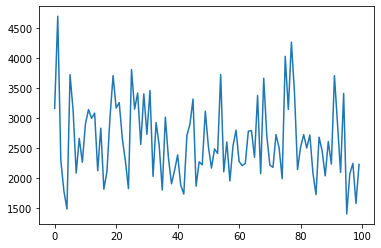

In [30]:
plt.plot(losses)